In [1]:
'''
https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce
https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

Cross Entropy (Binary CE, Categorical CE): https://gombru.github.io/2018/05/23/cross_entropy_loss/

RNN Mathemaical Intuition: 
    https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-recurrent-neural-network-873c29da73c7
    http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Example in python: https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

Nice with Graphics: 
    https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9
    https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

'''

'''
The steps of the approach are outlined below:
    - Convert abstracts from list of strings into list of lists of integers (sequences)
    - Create feature and labels from sequences
    - Build LSTM model with Embedding, LSTM, and Dense layers
    - Load in pre-trained embeddings
    - Train model to predict next work in sequence
    - Make predictions by passing in starting sequence
'''
# Patents dataset: https://www.patentsview.org/querydev/
# Query to download: https://www.patentsview.org/api/patents/query?q={"_or":[{"_text_all":{"patent_title":"neural%20network"}},{"_text_all":{"patent_abstract":"neural%20network"}}]}&f=["patent_title","patent_abstract"]&s=[{"patent_title":"asc"}]
# https://github.com/WillKoehrsen/recurrent-neural-networks/blob/master/notebooks/Deep%20Dive%20into%20Recurrent%20Neural%20Networks.ipynb

import csv
from keras_preprocessing.text import Tokenizer
import numpy as np

In [2]:
filename = 'patent_abstracts_short.csv'
# initializing the titles and rows list 
fields = [] 
abstracts = [] 

# reading csv file 
with open(filename, 'r', encoding="utf8") as csvfile:
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
      
    # extracting field names through first row 
    fields = next(csvreader)
    
    # extracting each data row one by one 
    for row in csvreader:
        # Take only abstracts
        abstracts.append(row[0]) 
  
    # get total number of rows 
    print("Total no. of rows: %d"%(csvreader.line_num)) 

# printing the field names 
print('Field names are:' + ', '.join(field for field in fields))
print('\nList of strings:')
print(abstracts[100])

'''
1. Remove punctuation and split strings into lists of individual words
2. Convert the individual words into integers
'''

# Don't remove punctuation or uppercase
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ")
tokenizer.fit_on_texts(abstracts)
sequences = tokenizer.texts_to_sequences(abstracts)
print('\nList of list of integers:')
print(sequences[100])

word_idx = tokenizer.word_index
print('\nNum of words in vocabulary=', len(word_idx)+1)

#Mapping of indexes to word
print('\nBack to word from indexes:')
idx_word = tokenizer.index_word
print(' '.join(idx_word[w] for w in sequences[100][:40]))

Total no. of rows: 1001
Field names are:patent_abstract, patent_title

List of strings:
An air-fuel ratio control system for an internal combustion engine, which is capable of accurately estimating an exhaust gas state parameter according to the properties of fuel, thereby making it possible to properly control the air-fuel ratio of a mixture. The air-fuel ratio control system 1 estimates an exhaust gas state parameter indicative of a state of exhaust gases, as an estimated exhaust gas state parameter (AF13 NN) by inputting a detected combustion state parameter (DCADLYIG) indicative of a combustion state of the mixture in the engine 3, and detected operating state parameters (NE, TW, PBA, IGLOG, TOUT) indicative of operating states of the engine 3, to a neural network (NN) configured as a network to which are input the combustion state parameter (DCADLYIG) and the operating state parameters (NE, TW, PBA, IGLOG, TOUT), and in which the exhaust gas state parameter is used as a teacher si

In [3]:
features = []
labels = []

training_length = 50

# Iterate through the sequences of tokens
# Every 50 words for training and 51st words is a label
for seq in sequences:

    # Create multiple training examples from each sequence
    for i in range(training_length, len(seq)):
        
        # Extract the features and label
        extract = seq[i - training_length:i + 1]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])
        
features = np.array(features)
print('features shape=',features.shape)
print('labels size=', len(labels))

features shape= (81174, 50)
labels size= 81174


In [4]:
num_words = len(word_idx)+1

#one hot encoding of labels
label_array = np.zeros((len(features), num_words), dtype=np.int8)
for example_index, word_index in enumerate(labels):
    label_array[example_index, word_index] = 1
print(label_array.shape)

print(label_array[100])
# To find the word corresponding to label
print(idx_word[np.argmax(label_array[100])])

(81174, 6561)
[0 0 0 ... 0 0 0]
of


In [5]:
from sklearn.utils import shuffle
TRAIN_FRACTION = 0.7
RANDOM_STATE = 50

def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
print(X_train.shape)
print(y_train.shape)

(56821, 50)
(56821, 6561)


In [6]:
# Download glove https://nlp.stanford.edu/projects/glove/
# DOwnload only 100 Dimension word2vec https://www.kaggle.com/anindya2906/glove6b#
glove_100_vectors = 'glove.6B.100d.txt'
glove = np.loadtxt(glove_100_vectors, dtype='str', comments=None, encoding="utf8")
print(glove.shape)

(400000, 101)


In [7]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

print(vectors[100], words[100])
print(vectors.shape)

[-3.9551e-01  5.4660e-01  5.0315e-01 -6.3682e-01 -4.5470e-01  3.0889e-01
 -4.9240e-02  2.7191e-01  3.1562e-01 -3.2879e-01  2.5089e-01  1.4508e-01
  3.5136e-01 -2.2793e-01 -1.5894e-01 -5.1527e-01 -2.7978e-01  3.6470e-01
 -3.9425e-01  3.3299e-01  4.3051e-01  1.8300e-01  2.5095e-01 -1.8547e-01
  3.4698e-01  5.5137e-02 -4.5979e-01 -8.2963e-01 -1.8523e-02 -3.6772e-01
  4.5566e-02  7.1052e-01 -2.2782e-02 -8.0889e-02  2.0685e-01  4.9855e-01
 -5.9794e-02 -8.0048e-03 -2.3823e-01 -3.3759e-01 -2.4201e-01 -2.3788e-01
 -1.1362e-03 -4.0395e-01 -4.4859e-01 -3.2189e-01  4.8405e-01 -2.7999e-02
  1.0148e-01 -9.3585e-01 -8.7522e-02 -3.9959e-01  3.6545e-01  1.3726e+00
 -3.0713e-01 -2.5940e+00  2.2431e-01 -4.1168e-02  1.7765e+00  4.0010e-01
 -1.0996e-01  1.4178e+00 -2.6154e-01  1.8617e-01  7.9328e-01 -1.1709e-01
  8.7541e-01  4.3911e-01  3.4711e-01 -2.8515e-01  7.6269e-02 -6.3038e-01
  1.6408e-01 -3.7053e-01  5.8485e-01 -1.5472e-01 -2.6382e-01 -1.8590e-01
 -7.5228e-01 -1.5752e-01  7.8539e-01 -1.8846e-02 -8

In [8]:
# Creating embedding matrix
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 388 words without pre-trained embeddings.


In [9]:
import gc
gc.enable()
del vectors
gc.collect()

0

In [10]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

c:\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """Find closest words to a query word in embeddings"""

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [12]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: this            Cosine Similarity: 0.8573
Word: part            Cosine Similarity: 0.8508
Word: one             Cosine Similarity: 0.8503
Word: of              Cosine Similarity: 0.8329
Word: same            Cosine Similarity: 0.8325
Word: first           Cosine Similarity: 0.821
Word: on              Cosine Similarity: 0.82
Word: its             Cosine Similarity: 0.8169
Word: as              Cosine Similarity: 0.8128


In [13]:
find_closest('neural', embedding_matrix, word_idx, idx_word, 10)

Query: neural

Word: neural          Cosine Similarity: 1.0
Word: neuronal        Cosine Similarity: 0.6841
Word: cortical        Cosine Similarity: 0.676
Word: plasticity      Cosine Similarity: 0.6625
Word: pathways        Cosine Similarity: 0.6534
Word: neurons         Cosine Similarity: 0.6485
Word: sensory         Cosine Similarity: 0.6391
Word: cognitive       Cosine Similarity: 0.6125
Word: brain           Cosine Similarity: 0.6082
Word: physiological   Cosine Similarity: 0.6022


In [14]:
find_closest('.', embedding_matrix, word_idx, idx_word, 10)

. not found in vocab.


In [15]:
find_closest('wonder', embedding_matrix, word_idx, idx_word)

wonder not found in vocab.


In [16]:
find_closest('dnn', embedding_matrix, word_idx, idx_word)

dnn has no pre-trained embedding.


In [17]:
LSTM_CELLS = 64

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         656100    
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6561)              846369    
Total params: 1,553,029
Trainable params: 896,929
Non-trainable params: 656,100
__________________________________________

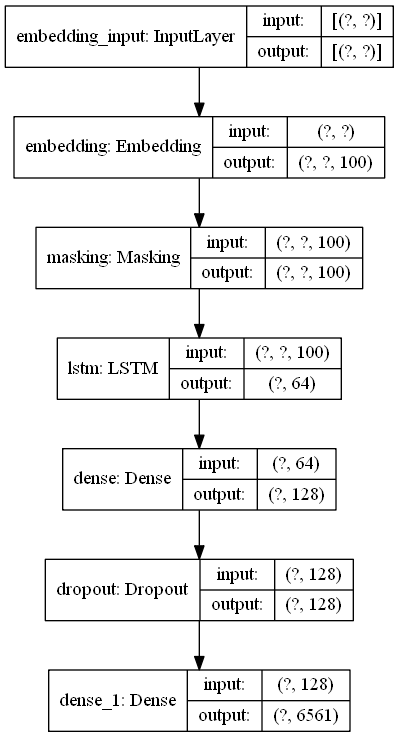

In [19]:
from IPython.display import Image
model_name = 'pre-trained-rnn'
model_dir = './'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048
EPOCHS = 150
VERBOSE = 0
SAVE_MODEL = True

def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

In [21]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))
print(history)

In [22]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'{model_dir}{model_name}.h5')
    r = model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model

In [23]:
model = load_and_evaluate(model_name, return_model=True)

12/12 [==============================] - 5s 435ms/step - loss: 6.3239 - accuracy: 0.0901
Cross Entropy: 6.3239
Accuracy: 9.01%
